## Dividing into training and testing

##### Import the necessary libraries:

In [3]:
import os
import random
import shutil

##### Define the ratio of data you want to allocate for training and testing. For example, you can choose to allocate 80% for training and 20% for testing:

In [4]:
train_ratio = 0.8
test_ratio = 0.2


##### Create two new directories for the training and testing data:

In [6]:
os.makedirs('../data/Train', exist_ok=True)
os.makedirs('../data/Test', exist_ok=True)


##### Loop through each plant folder, and for each folder, create subdirectories in the Train and Test folders to store the respective data:

In [9]:
for plant_folder in os.listdir('../data/Segmented Medicinal Leaf Images'):
    plant_path = os.path.join('../data/Segmented Medicinal Leaf Images', plant_folder)
    train_path = os.path.join('../data/Train', plant_folder)
    test_path = os.path.join('../data/Test', plant_folder)
    
    # Create training and testing directories for each plant
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    
    # List all the images in the plant folder
    images = os.listdir(plant_path)
    
    # Randomly shuffle the images
    random.shuffle(images)
    
    # Calculate the number of images for training and testing
    num_train = int(len(images) * train_ratio)
    
    # Split the images into training and testing sets
    train_images = images[:num_train]
    test_images = images[num_train:]
    
    # Copy the images to their respective directories
    for image in train_images:
        src = os.path.join(plant_path, image)
        dest = os.path.join(train_path, image)
        shutil.copy(src, dest)
    
    for image in test_images:
        src = os.path.join(plant_path, image)
        dest = os.path.join(test_path, image)
        shutil.copy(src, dest)


## Importing library and modeules

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Train and Test data

#### learn more about pathlib
* https://towardsdatascience.com/10-examples-to-master-python-pathlib-1249cc77de0b

In [17]:
import pathlib
train_dir = pathlib.Path("../data/Train/")
test_dir = pathlib.Path("../data/Test/")

#### New function/Concept 'glog()'
* The glob module is a useful part of the Python standard library. glob (short for global) is used to return all file paths that match a specific pattern.

* We can use glob to search for a specific file pattern, or perhaps more usefully, search for files where the filename matches a certain pattern by using wildcard characters.
* Learn more about glob
* https://towardsdatascience.com/the-python-glob-module-47d82f4cbd2d

In [18]:
# Total number of images in training data-set

image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

1455

## Showing / Visualize Image


* here we are using matplotlib for visualizing our data
* we have open our image and converted to digits using Pillow


(1200, 1600, 3)
../data/Train/Alpinia Galanga (Rasna)/AG-S-042.jpg
(1200, 1600, 3)
../data/Train/Alpinia Galanga (Rasna)/AG-S-011.jpg
(1200, 1600, 3)
../data/Train/Alpinia Galanga (Rasna)/AG-S-003.jpg


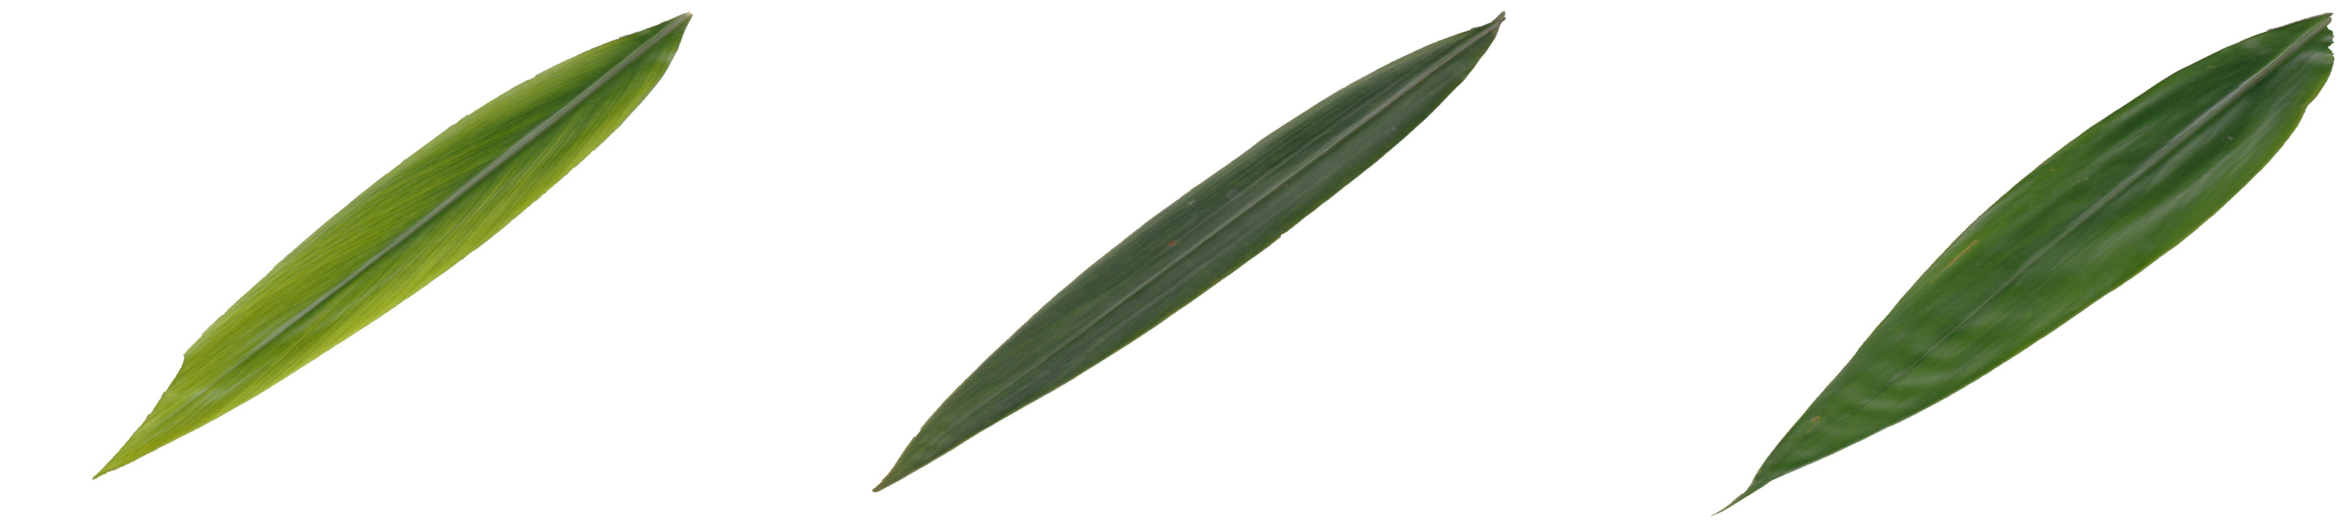

In [19]:
import matplotlib.pyplot as plt
import PIL
import cv2
fruits = list(train_dir.glob('Alpinia Galanga (Rasna)/*.jpg'))

plt.figure(figsize=(30, 30))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    imgshape = cv2.imread(str(fruits[i]), cv2.IMREAD_UNCHANGED)
    print(imgshape.shape)
    print(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Setting Up variables

In [20]:
batch_size = 32
img_height = 1200
img_width = 1600


## Collecting Data
#### Used keras 'image_dataset_from_directory' API for collrcting data from directories
* Learn more about 'image_dataset_from_directory' 
* https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

ImportError: cannot import name 'deserialize_keras_object' from partially initialized module 'keras.saving.legacy.serialization' (most likely due to a circular import) (/home/anurag/anaconda3/lib/python3.11/site-packages/keras/saving/legacy/serialization.py)

In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

ImportError: cannot import name 'deserialize_keras_object' from partially initialized module 'keras.saving.legacy.serialization' (most likely due to a circular import) (/home/anurag/anaconda3/lib/python3.11/site-packages/keras/saving/legacy/serialization.py)

## Visualizing friuts by classes

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [1]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

NameError: name 'plt' is not defined

# Preprocessing/Setting Up Base Model

### prefetch the data for faster training while model is trained
* Learning more about prefetch and AUTOTUNE
* prefetch : https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4#:~:text=Prefetching%20solves%20the,they%20are%20requested.
* AUTOTUNE : https://stackoverflow.com/questions/56613155/tensorflow-tf-data-autotune

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augumentation
* Data augmentation is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.



In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

### Using ResNEt Model for Transfer Learning
* Learn more about ResNet by going through paper
* https://paperswithcode.com/method/resnet

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

* setting base model trainable to False so model take less time

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

# Building Model

In [ ]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

# Training the model

In [ ]:
model.evaluate(val_ds)

* evolution accuracy is very bad but wait for traning 

In [ ]:
epochs = 15

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

# Visualization of Accuracy and loss

### Loss 

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

### Accuracy

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

# I hope you like this ;)

# Checking prediction on validation data-set with visualisation

In [ ]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')



# Saving model

In [ ]:
model_version = 1
model.save(f"./models/{model_version}")

# Zipping all the files in models

In [ ]:
import shutil
shutil.make_archive("model", 'zip', './')